In [1]:
import matplotlib.pyplot as plt
import numpy as np

import os

import tensorflow as tf
from tensorflow import keras
from keras.utils import image_dataset_from_directory
from keras import Sequential, Input
from keras.layers import RandomFlip, RandomContrast, RandomRotation, RandomZoom, Rescaling
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, BatchNormalization, Dropout, Flatten
from keras.applications import EfficientNetV2L as base
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy as scc
from keras.callbacks import EarlyStopping, LearningRateScheduler

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

f'Tensorflow version: {tf.__version__}'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'Tensorflow version: 2.12.0'

In [2]:
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 2


In [3]:
image_size = 256
batch_size = 128
epochs = 100
lr_init = .003

train_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/input/medical-scan-classification-dataset/Cervical Cancer/Cervical Cancer',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/input/medical-scan-classification-dataset/Cervical Cancer/Cervical Cancer',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size)

Found 25000 files belonging to 5 classes.
Using 20000 files for training.
Found 25000 files belonging to 5 classes.
Using 5000 files for validation.


In [4]:
class_names = train_ds.class_names
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)
class_names

['Dyskeratotic',
 'Koilocytotic',
 'Metaplastic',
 'Parabasal',
 'Superficial-Intermediat']

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [6]:
es = EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.001, restore_best_weights=True)

def create_model(base_model):
    input = Input(shape=(image_size, image_size, 3))
    x = RandomFlip('horizontal')(input)
    x = RandomRotation(0.2)(x)
    x = RandomZoom(0.2,0.2)(x)
    x = RandomContrast(0.2)(x)
    b_model = base_model(x)
    flatten = Flatten()(b_model)
    x = Dense(1024,activation='relu')(flatten)
    norm = BatchNormalization()(x)
    x = Dense(512,activation='swish')(flatten)
    norm = BatchNormalization()(x)
    x = Dense(128,activation='relu')(norm)
    norm = BatchNormalization()(x)
    dropout = Dropout(0.2)(norm)
    x = Dense(len(class_names))(dropout)
    model = tf.keras.models.Model(inputs=input, outputs=x)
    
    model.compile(optimizer=Adam(lr_init),
              loss=scc(from_logits=True),
              metrics=['accuracy'])
    return model

def schedule(epoch,lr):
    if epoch < 5:
        return ((epoch)+1)*lr_init/5
    if epoch < 15:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_scheduler = LearningRateScheduler(schedule,verbose=1)

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [7]:
with strategy.scope():
    base_model = base(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet')
    base_model.trainable = False
    model = create_model(base_model)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 256, 256, 3)      0         
 rast)                                                           
                                                                 
 efficientnetv2-l (Functiona  (None, 8, 8, 1280)       117746

In [9]:
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                   callbacks=[es,lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.0006000000000000001.
Epoch 1/100


2023-10-10 10:00:36.546682: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-l/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


157/157 [==============================] - 385s 2s/step - loss: 0.5764 - accuracy: 0.7979 - val_loss: 0.4387 - val_accuracy: 0.8566 - lr: 6.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0012000000000000001.
Epoch 2/100
157/157 [==============================] - 262s 2s/step - loss: 0.3392 - accuracy: 0.8759 - val_loss: 0.3243 - val_accuracy: 0.8885 - lr: 0.0012

Epoch 3: LearningRateScheduler setting learning rate to 0.0018000000000000002.
Epoch 3/100
157/157 [==============================] - 266s 2s/step - loss: 0.2636 - accuracy: 0.9053 - val_loss: 0.2469 - val_accuracy: 0.9139 - lr: 0.0018

Epoch 4: LearningRateScheduler setting learning rate to 0.0024000000000000002.
Epoch 4/100
157/157 [==============================] - 260s 2s/step - loss: 0.2223 - accuracy: 0.9203 - val_loss: 0.2482 - val_accuracy: 0.9180 - lr: 0.0024

Epoch 5: LearningRateScheduler setting learning rate to 0.003.
Epoch 5/100
157/157 [==============================] - 262s 2s/step - loss: 

In [10]:
model.save('cervical_cancer.h5')

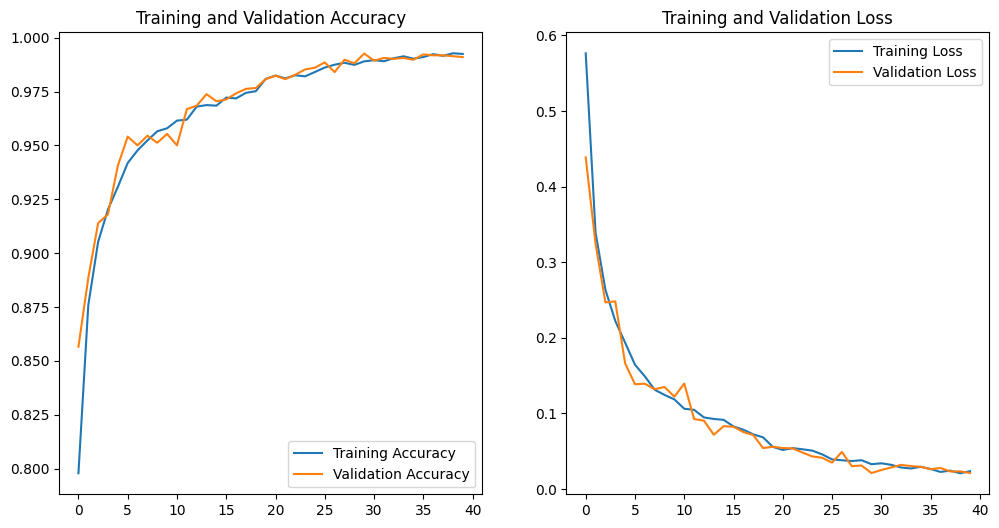

In [11]:
plot_history(history)

In [12]:
model.evaluate(test_ds)

20/20 [==============================] - 35s 2s/step - loss: 0.0243 - accuracy: 0.9910


[0.024261584505438805, 0.991015613079071]

In [13]:
model.evaluate(val_ds)

20/20 [==============================] - 38s 1s/step - loss: 0.0240 - accuracy: 0.9922


[0.024038322269916534, 0.9922131299972534]